In [10]:
import pandas as pd
import osmnx as ox
import gpxpy
from shapely.geometry import Point

In [15]:
def process_gpx_to_df(file_name):
    # Parse the GPX file
    gpx = gpxpy.parse(open(file_name))
    
    # Extract track points
    points = [
        (point.latitude, point.longitude) 
        for track in gpx.tracks 
        for segment in track.segments 
        for point in segment.points
    ]
    
    # Create DataFrame
    data = [
        (point.longitude, point.latitude, point.elevation, point.time, segment.get_speed(idx))
        for track in gpx.tracks
        for segment in track.segments
        for idx, point in enumerate(segment.points)
    ]
    columns = ["Longitude", "Latitude", "Altitude", "Time", "Speed"]
    gpx_df = pd.DataFrame(data, columns=columns)
    
    return gpx_df, points

In [16]:
# file_name = "data/routes/Eschborn_Frankfurt_24_Skoda_Velotour_Classic.gpx"
file_name = "data/routes/RCH_Staufen_Bike_2024_Graveltour_Strong_77km.gpx"
df, points = process_gpx_to_df(file_name)

In [18]:
import folium
mymap = folium.Map(
    location=[df.Latitude.mean(), df.Longitude.mean()], 
    zoom_start=11,
#     tiles='CartoDBPositron',
    tiles='OpenStreetMap',
)
folium.PolyLine(
    points,
    name="Route",
    color='red', 
    weight=10, 
    opacity=.4
).add_to(mymap)
folium.LayerControl().add_to(mymap)
mymap

In [20]:
# Define the center point of your area of interest
center_point = points[0]

# Create a graph from the road network around the center point
G = ox.graph_from_point(center_point, dist=1000, network_type='all')

In [23]:
help(ox.get_nearest_edge)

Help on function get_nearest_edge in module osmnx.distance:

get_nearest_edge(G, point, return_geom=False, return_dist=False)
    Do not use, deprecated.
    
    Parameters
    ----------
    G : networkx.MultiDiGraph
        deprecated, do not use
    point : tuple
        deprecated, do not use
    return_geom : bool
        deprecated, do not use
    return_dist : bool
        deprecated, do not use
    
    Returns
    -------
    tuple



In [24]:
nearest_edges = []
for point in points:
    nearest_edge = ox.get_nearest_edge(G, (point[0], point[1]))
    nearest_edges.append(nearest_edge)


/opt/anaconda3/lib/python3.7/site-packages/osmnx/distance.py:387: UserWarning: The `get_nearest_edge` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_edges` instead.
  warnings.warn(msg)
/opt/anaconda3/lib/python3.7/site-packages/osmnx/distance.py:288: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy))].distance(Point(xy))
/opt/anaconda3/lib/python3.7/site-packages/osmnx/distance.py:387: UserWarning: The `get_nearest_edge` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_edges` instead.
  warnings.warn(msg)
/opt/anaconda3/lib/python3.7/site-packages/osmnx/distance.py:288: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' 

In [25]:
surface_quality = []
for edge in nearest_edges:
    u, v, key = edge
    edge_data = G.edges[(u, v, key)]
    surface_quality.append(edge_data.get('surface', 'Unknown'))


In [28]:
df = pd.DataFrame({'Point': points, 'Nearest Edge': nearest_edges, 'Surface Quality': surface_quality})
print(df)


                      Point                Nearest Edge Surface Quality
0     (50.067595, 8.416109)  (3469847942, 313191580, 0)         Unknown
1     (50.067522, 8.415832)  (313191580, 3469847942, 0)         Unknown
2     (50.067475, 8.415651)  (313191587, 3469847942, 0)         Unknown
3      (50.067344, 8.41527)  (313191587, 3469847942, 0)         Unknown
4     (50.068325, 8.414568)      (313191587, 586814, 0)         Unknown
...                     ...                         ...             ...
1263  (50.068325, 8.414568)      (313191587, 586814, 0)         Unknown
1264   (50.067344, 8.41527)  (313191587, 3469847942, 0)         Unknown
1265  (50.067475, 8.415651)  (313191587, 3469847942, 0)         Unknown
1266  (50.067651, 8.416321)   (313191580, 313191488, 0)         Unknown
1267  (50.067713, 8.416667)   (313191488, 313191580, 0)         Unknown

[1268 rows x 3 columns]


In [29]:
import numpy as np
df["count"] = np.where(df["Surface Quality"]=="Unknown", 1, 0)

In [30]:
df["count"].sum()

1268

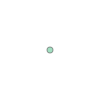

In [33]:
Point(points[0]).within()